## Full Name: Javad Razi
## Student ID: 401204354


# Introduction

In this practical assignment, we will practice using PyTorch to implement neural networks. We will work with the Fashion-MNIST dataset, and after visualizing the data to get familiar with it, we will use t-SNE and implement the PCA algorithm to reduce the dimensionality of the data for visualization in a 2D plot.

## Tasks

1. Implement the PCA algorithm.
2. Apply PCA and t-SNE to the Fashion-MNIST test set.
3. Train a simple stacked autoencoder consisting of several MLP layers.
4. Use PCA and t-SNE to visualize the encoding of the test set calculated by the trained autoencoder.
5. Add a classification layer on top of the autoencoder's encoder and use its trained weights to predict each image label.

## Instructions

1. For task 1, you can use the following steps:

    a. Import the necessary libraries.
    b. Define the PCA class.
    c. Instantiate the PCA class and fit it to the Fashion-MNIST test set.
    d. Transform the Fashion-MNIST test set using the fitted PCA model.

2. For task 2, you can use the following steps:

    a. Import the necessary libraries.
    b. Instantiate the PCA and t-SNE classes.
    c. Transform the Fashion-MNIST test set using the PCA model.
    d. Transform the PCA-transformed Fashion-MNIST test set using the t-SNE model.
    e. Visualize the t-SNE-transformed Fashion-MNIST test set using a scatter plot.

3. For task 3, you can use the following steps:

    a. Import the necessary libraries.
    b. Define the stacked autoencoder class.
    c. Instantiate the stacked autoencoder class and train it on the Fashion-MNIST training set.

4. For task 4, you can use the following steps:

    a. Transform the Fashion-MNIST test set using the PCA model.
    b. Transform the PCA-transformed Fashion-MNIST test set using the trained autoencoder's encoder.
    c. Visualize the t-SNE-transformed encoding of the Fashion-MNIST test set using a scatter plot.

5. For task 5, you can use the following steps:

    a. Import the necessary libraries.
    b. Define the classification layer class.
    c. Add the classification layer to the trained autoencoder's encoder.
    d. Train the classification layer on the Fashion-MNIST training set.
    e. Evaluate the classification layer on the Fashion-MNIST test set.

## Conclusion

In this practical assignment, we have learned how to use PyTorch to implement neural networks and apply dimensionality reduction techniques to data visualization. We have also learned how to train and evaluate classification models.


# Import Requirements

In [1]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from random import sample

# Config

In [2]:
RANDOM_STATE = 42
random.seed(RANDOM_STATE)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Load Fashion MNIST Dataset

In [4]:
fashion_mnist = fetch_openml(name='Fashion-MNIST')

X, y = fashion_mnist.data.astype('float32'), fashion_mnist.target.astype('int')

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [42]:
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress",
    "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

In [6]:
print(X.shape)

(70000, 784)


In [7]:
print(y.shape)

(70000,)


In [8]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.1, random_state=RANDOM_STATE)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.075, random_state=RANDOM_STATE)

print(f'Shape of Training Data: {X_train.shape}')
print(f'Shape of Test Data: {X_test.shape}')
print(f'Shape of Validation Data: {X_val.shape}')

Shape of Training Data: (58275, 784)
Shape of Test Data: (7000, 784)
Shape of Validation Data: (4725, 784)


# Visualization

In [9]:
def visualize_one_image_per_category(X, y, class_names):
    unique_labels = np.unique(y)
    fig, ax = plt.subplots(1, len(unique_labels), figsize=(20, 4))

    for i, label in enumerate(unique_labels):
        # Find the first image for the current label
        image_idx = np.where(y == label)[0][0]
        image = X.iloc[image_idx].values.reshape(28, 28)  # Use .iloc to access by index

        ax[i].imshow(image, cmap='gray')
        ax[i].set_title(class_names[label])
        ax[i].axis('off')

    plt.show()

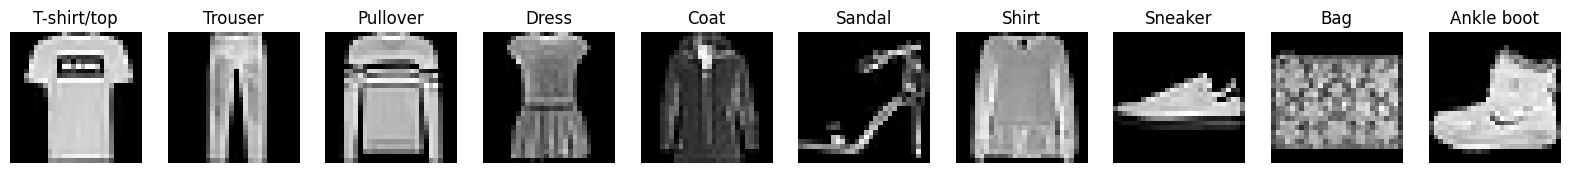

In [10]:
visualize_one_image_per_category(X, y, class_names)


# Dimensionality Reduction

In [11]:
def visualize_2d(reduced_data, labels, method='PCA', class_names=class_names):
    plt.figure(figsize=(12, 6))
    scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='tab10', alpha=0.5, s=5)
    plt.title(f'{method} Visualization')
    plt.xlabel(f'{method} Component 1')
    plt.ylabel(f'{method} Component 2')

    plt.colorbar(scatter, ticks=np.arange(len(class_names)), label='Class',
                 format=plt.FuncFormatter(lambda val, loc: class_names[int(val)]))

    for i, label in enumerate(class_names):
        indices = labels == i
        plt.text(reduced_data[indices, 0].mean(), reduced_data[indices, 1].mean(),
                 label, fontsize=10, ha='center', va='center')

    plt.show()

#### For this part and the following part, apply PCA and t-SNE to test dataset, respectively.

## PCA (10 points)

### Principal Component Analysis (PCA) - Step-by-Step Explanation

Principal Component Analysis (PCA) is a technique used for dimensionality reduction and data visualization. It aims to transform a dataset into a new coordinate system (a lower-dimensional space) while retaining the most important information.

1. **Center the Data**:
   - Calculate the mean of each feature in the dataset.
   - Subtract the mean from each feature value to center the data around the origin. This ensures that the new coordinate system is centered at the origin.

2. **Calculate Covariance Matrix**:
   - Compute the covariance matrix for the centered data.
   - The covariance matrix provides information about how features vary with each other.

3. **Calculate Eigenvectors and Eigenvalues**:
   - Compute the eigenvectors and eigenvalues of the covariance matrix.
   - Eigenvectors represent the directions of maximum variance, and eigenvalues quantify the amount of variance in those directions.

4. **Sort Eigenvectors**:
   - Sort the eigenvectors based on their corresponding eigenvalues in descending order.
   - The eigenvectors with higher eigenvalues capture more variance and are prioritized.

5. **Select Principal Components**:
   - Choose the top `n` eigenvectors (principal components) based on the desired number of dimensions for the reduced dataset.
   - These eigenvectors represent the directions in the original feature space that capture the most variance.

6. **Project Data**:
   - Project the centered data onto the lower-dimensional subspace formed by the selected principal components.
   - Multiply the centered data by the selected eigenvectors to obtain the new representation in the lower-dimensional space.

7. **Transform the Original Data:**:
   - Multiply the original data by the projection matrix to obtain the new lower-dimensional representation of the data.




PCA helps in reducing the dimensionality of the dataset while retaining the most critical information. The first few principal components capture the majority of the variance, allowing for effective visualization and analysis of the data in a lower-dimensional space.


In [12]:
import numpy as np

class PCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.means = None
        self.eigenvectors = None

    def fit(self, X):
        self.means = np.mean(X, axis=0)
        X_centered = X - self.means

        covariance_matrix = np.cov(X_centered, rowvar=False)

        eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

        idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]

        self.eigenvectors = eigenvectors[:, :self.n_components]

    def transform(self, X):
        X_centered = X - self.means

        return np.dot(X_centered, self.eigenvectors)

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)


## Apply `PCA` and `t-SNE` to the testset.

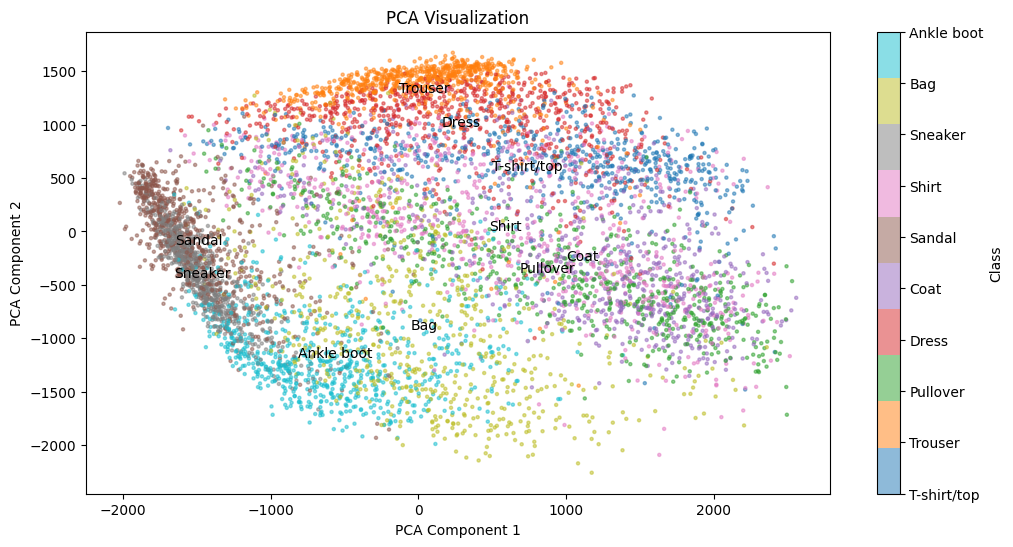

In [13]:
pca = PCA(2)
X_pca = pca.fit_transform(X_test)
visualize_2d(X_pca, y_test, 'PCA')

## t-SNE

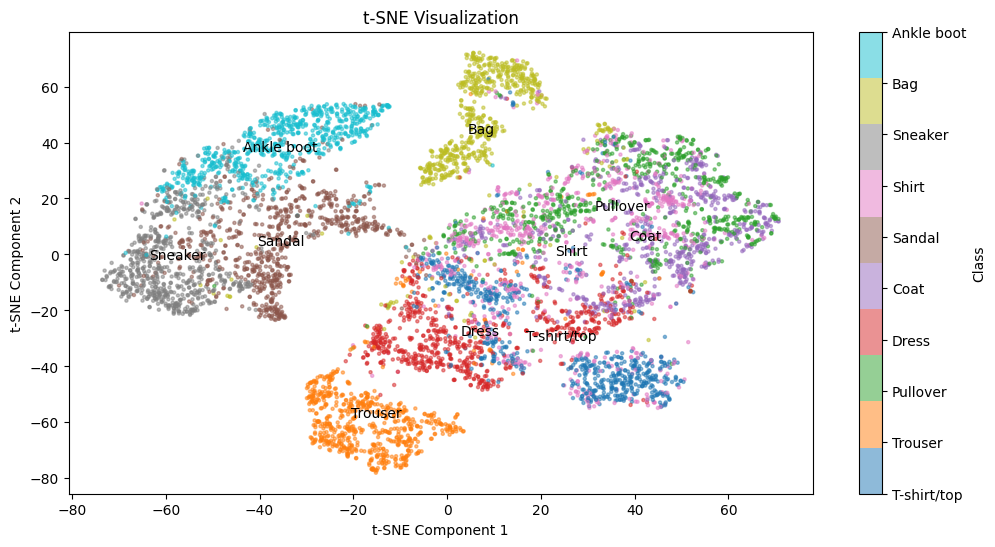

In [14]:
tsne = TSNE(n_components=2, random_state=RANDOM_STATE)
X_tsne = tsne.fit_transform(X_test)
visualize_2d(X_tsne, y_test, 't-SNE')

## **Question:** (10 points)

- Explain the differences between PCA (Principal Component Analysis) and t-SNE (t-distributed Stochastic Neighbor Embedding) in terms of their preservation of distance, handling of non-linearity, and preservation of data structure. How does each technique aim to maintain distance or similarity relationships between data points in the lower-dimensional space, handle non-linear relationships in the data, and preserve the global or local data structure? Provide examples or illustrations to support your explanation.

## Solution:

PCA and t-SNE are both techniques used for dimensionality reduction, but they differ significantly in their approaches and outcomes:

1. Preservation of Distance:
PCA preserves linear variance and projects data into a new coordinate system where the greatest variances lie on the axes. It maintains global structure but can fail to capture complex, non-linear relationships.
t-SNE, on the other hand, preserves local distances and similarities, especially the structure of the nearest neighbors. It can capture non-linear structures by converting high-dimensional Euclidean distances into conditional probabilities representing similarities.

2. Handling of Non-linearity:
PCA is a linear technique and is not designed to reduce dimensions based on non-linear relationships.
t-SNE excels in handling non-linear data structures. It maps complex manifolds by focusing on local relationships, often revealing clusters at several scales on a single map.

3. Preservation of Data Structure:
PCA tends to preserve the global data structure and can sometimes blend distinct, local clusters if the global variance is more pronounced in other areas of the data.
t-SNE preserves local data structures and can separate clusters that are not distinguishable by PCA. However, t-SNE does not preserve global relationships and distances between clusters can be arbitrary.

Both PCA and t-SNE aim to maintain certain relationships between data points when mapping to a lower-dimensional space. PCA maintains the global structure by projecting the data along axes of maximum variance, while t-SNE maintains local similarities and is more focused on revealing local clusters and data patterns.

Examples:
    In an image dataset where global brightness varies more than the content of the images, PCA might prioritize brightness variance over the actual image content, while t-SNE would group similar images regardless of brightness.
    In a dataset with nested clusters, PCA might project the data in a way that the clusters overlap, while t-SNE would unfold the manifolds and separate the clusters in the lower-dimensional space.

# Deep Auto-Encoder For Representation Learning

In the previous section, you observed the results of applying two renowned dimensionality reduction techniques to the data. Additionally, a representation of the data can be learned by an **autoencoder**, which is a neural network that takes an image (or a noisy version of it) as input and attempts to reconstruct the image after encoding the pixels.

## Create Dataset & Datalodaer (5 points)

- Note: If you are unfamiliar with PyTorch's `Dataset`, `Transforms`, and `Dataloader` modules, consult the following link for assistance: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [15]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class CustomFashionMNISTDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image = self.X[idx].reshape(28, 28).astype('uint8')
        label = self.y[idx]

        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        return image, label

BATCH_SIZE = 64
train_transform = transforms.Compose([transforms.ToTensor()])
test_transform = transforms.Compose([transforms.ToTensor()])

train_dataset = CustomFashionMNISTDataset(X_train, y_train, train_transform)
val_dataset = CustomFashionMNISTDataset(X_val, y_val, test_transform)
test_dataset = CustomFashionMNISTDataset(X_test, y_test, test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


## Define Model (5 points)

**Caution:** You may only use multilayer perceptron (MLP) layers.

- Note: If you are unfamiliar with custom models using PyTorch, consult the following link for assistance:
https://pytorch.org/tutorials/beginner/examples_nn/polynomial_module.html

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3),  # Compressed representation
        )
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),  # Output a value between 0 and 1
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
autoencoder = Autoencoder()
autoencoder.to(device)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): ReLU()
    (6): Linear(in_features=12, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=12, bias=True)
    (1): ReLU()
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Sigmoid()
  )
)

## Trainin Loop (10 points)

#### Complete the `train_at_epoch`, `test_ae`, and `train_ae` functions.

#### Define your `Optimizer`, `Learning Rate Scheduler`, and `Criterion` inside the `train_ae` function.


In [17]:
from torch import optim
import torch.nn as nn

def train_ae_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(data.size(0), -1).to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    mean_loss = total_loss / len(train_loader)
    return mean_loss

def test_ae(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.view(data.size(0), -1).to(device)
            output = model(data)
            loss = criterion(output, data)
            total_loss += loss.item()
    mean_loss = total_loss / len(test_loader)
    return mean_loss

def train_ae(model, train_loader, val_loader, num_epochs, learning_rate=1e-4, device=device):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_loss_history = []
    val_loss_history = []
    for epoch in range(num_epochs):
        train_loss = train_ae_epoch(model, train_loader, criterion, optimizer, device)
        val_loss = test_ae(model, val_loader, criterion, device)
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    return train_loss_history, val_loss_history

In [18]:
ae_train_loss_history, ae_val_loss_history = train_ae(autoencoder, train_loader, val_loader, 50)

Epoch 1/50, Train Loss: 0.0883, Val Loss: 0.0572
Epoch 2/50, Train Loss: 0.0457, Val Loss: 0.0398
Epoch 3/50, Train Loss: 0.0380, Val Loss: 0.0368
Epoch 4/50, Train Loss: 0.0347, Val Loss: 0.0333
Epoch 5/50, Train Loss: 0.0324, Val Loss: 0.0319
Epoch 6/50, Train Loss: 0.0312, Val Loss: 0.0309
Epoch 7/50, Train Loss: 0.0303, Val Loss: 0.0300
Epoch 8/50, Train Loss: 0.0296, Val Loss: 0.0294
Epoch 9/50, Train Loss: 0.0290, Val Loss: 0.0289
Epoch 10/50, Train Loss: 0.0286, Val Loss: 0.0285
Epoch 11/50, Train Loss: 0.0282, Val Loss: 0.0282
Epoch 12/50, Train Loss: 0.0279, Val Loss: 0.0279
Epoch 13/50, Train Loss: 0.0276, Val Loss: 0.0276
Epoch 14/50, Train Loss: 0.0274, Val Loss: 0.0274
Epoch 15/50, Train Loss: 0.0271, Val Loss: 0.0271
Epoch 16/50, Train Loss: 0.0269, Val Loss: 0.0269
Epoch 17/50, Train Loss: 0.0267, Val Loss: 0.0267
Epoch 18/50, Train Loss: 0.0266, Val Loss: 0.0266
Epoch 19/50, Train Loss: 0.0264, Val Loss: 0.0265
Epoch 20/50, Train Loss: 0.0263, Val Loss: 0.0263
Epoch 21/

### **Advantages of Using PyTorch Lightning for Training Neural Networks**

When working on training neural networks, it's essential to choose the right tools and frameworks to ensure efficient development, robustness, and maintainability of the code. PyTorch Lightning is a popular and powerful framework that simplifies the training process and offers several advantages over writing the training loop from scratch. In this exercise, we will explore these benefits by comparing manual implementation with PyTorch Lightning.

1. **Structured and Readable Code:**
PyTorch Lightning enforces a clear structure by separating the PyTorch components (such as model, optimizer, and scheduler) into dedicated methods like training_step, validation_step, and configure_optimizers. This separation results in more readable and organized code, making it easier to understand and maintain.

2. **Reduced Boilerplate Code:**
Writing a training loop involves a significant amount of boilerplate code for handling various aspects of training, such as iterating over the dataset, updating parameters, and logging metrics. PyTorch Lightning abstracts away much of this boilerplate, allowing you to focus on the essential components of your model and experiment.

3. **Flexibility and Customization:**
Despite providing a high-level interface, PyTorch Lightning remains flexible and allows for customization. Users can override specific methods to tailor the training process to their needs while leveraging the standardized structure provided by the framework.

4. **Enhanced Reproducibility:**
PyTorch Lightning promotes code modularity and follows best practices, contributing to enhanced reproducibility. With a consistent structure across experiments, it becomes easier to replicate and compare results.

5. **Integration with Advanced Features:**
PyTorch Lightning seamlessly integrates with advanced features such as distributed training, mixed-precision training, and automatic optimization, among others. These features are often complex to implement manually but can be easily utilized with PyTorch Lightning.

In summary, PyTorch Lightning provides a high-level and well-structured interface for training neural networks, offering benefits such as code readability, reduced boilerplate, flexibility, reproducibility, integration with advanced features, and a vibrant community. By using PyTorch Lightning, we can expedite the development process, enhance code quality, and facilitate experimentation and research in the field of deep learning.**

## Migrate to PL

#### In addition to all components defined in the preceding training phase, incorporate the early stopping module from the PyTorch Lightning API and a model checkpoint that saves the best model in each epoch.

In [19]:
%pip install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 17.6 MB/s eta 0:00:00


### Complete The Code For the PL Trainer (15 point)

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

class AE_Trainer(pl.LightningModule):
    def __init__(self, model):
        super(AE_Trainer, self).__init__()
        self.model = model
        self.criterion = nn.MSELoss()
        self.train_losses = []  # To store training loss history
        self.val_losses = []    # To store validation loss history

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, _ = batch
        x = x.view(x.size(0), -1)
        x_hat = self.model(x)
        loss = self.criterion(x_hat, x)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def on_train_epoch_end(self):
        train_loss_avg = self.trainer.callback_metrics['train_loss_epoch']
        self.train_losses.append(train_loss_avg.item())

    def validation_step(self, batch, batch_idx):
        x, _ = batch
        x = x.view(x.size(0), -1)
        x_hat = self.model(x)
        loss = self.criterion(x_hat, x)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def on_validation_epoch_end(self):
        val_loss_avg = self.trainer.callback_metrics['val_loss']
        self.val_losses.append(val_loss_avg.item())

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss',
            },
        }


autoencoder = Autoencoder()
ae_trainer = AE_Trainer(autoencoder)

early_stopping = EarlyStopping('val_loss', patience=5)
checkpoint_callback = ModelCheckpoint(dirpath='checkpoints/', save_top_k=1, monitor='val_loss')

trainer = pl.Trainer(
    max_epochs=50,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    callbacks=[early_stopping, checkpoint_callback],
)

trainer.fit(ae_trainer, train_loader, val_loader)
autoencoder = ae_trainer.model

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:634: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type        | Params
------------------------------------------
0 | model     | Autoencoder | 219 K 
1 | criterion | MSELoss     | 0     
------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.880     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


## Visualize Losses

##### Visualize Train_Loss and Val_Loss durining the training phase.

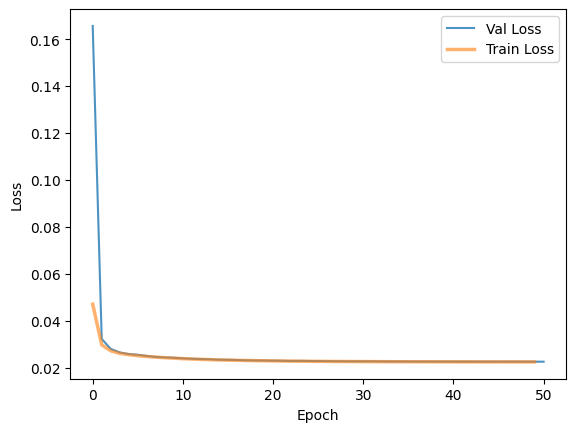

In [38]:
plt.plot(ae_trainer.val_losses, label='Val Loss', linewidth=1.5, alpha=0.8)
plt.plot(ae_trainer.train_losses, label='Train Loss', linewidth=2.5, alpha=0.6)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Evaluate on Testset

In [40]:
if torch.cuda.is_available():
    device = 'cuda:0'

    autoencoder.to(device)

    test_loader = [(data.to(device), target) for data, target in test_loader]

test_ae(autoencoder, test_loader, nn.MSELoss(), device)


0.022352541170336984

## Visualize Model Output (8 points)


##### For each category in the test set:

1. Randomly select an image from that category.
2. Generate a reconstruction of the image.
3. Display the original image and its reconstruction side-by-side.


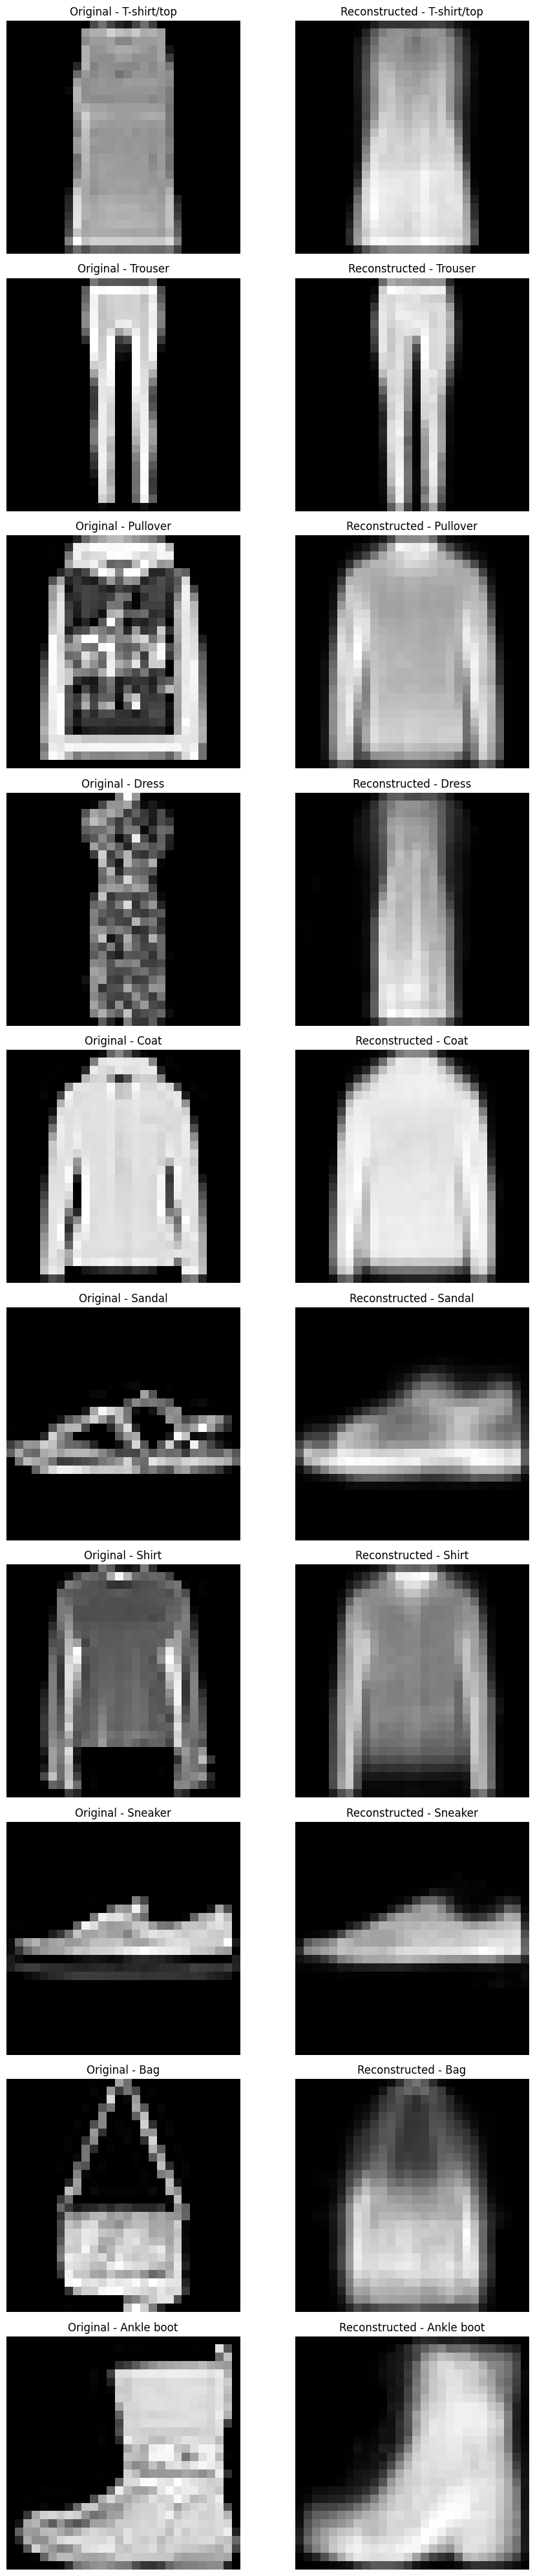

In [43]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def visualize_input_reconstructed(autoencoder, test_loader, device, class_names):
    autoencoder.eval()
    fig, axes = plt.subplots(nrows=len(class_names), ncols=2, figsize=(10, 4 * len(class_names)))

    with torch.no_grad():
        for i, class_name in enumerate(class_names):
            # Find an image of the given class
            for images, labels in test_loader:
                idx = (labels == i).nonzero(as_tuple=True)[0][0]
                original_image = images[idx]
                break

            # Generate reconstruction
            reconstructed_image = autoencoder(original_image.view(1, -1).to(device)).cpu().view_as(original_image)

            # Plot the original image
            axes[i, 0].imshow(original_image.cpu().squeeze(), cmap='gray')

            axes[i, 0].set_title(f'Original - {class_name}')
            axes[i, 0].axis('off')

            # Plot the reconstructed image
            axes[i, 1].imshow(reconstructed_image.cpu().squeeze(), cmap='gray')
            axes[i, 1].set_title(f'Reconstructed - {class_name}')
            axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

visualize_input_reconstructed(autoencoder, test_loader, device, class_names)


## Visualize Embeddings (5 points)

Generate image embeddings for the test dataset.

In [44]:
def generate_embeddings(autoencoder, test_loader, device):
    embeddings = []
    autoencoder.eval()
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            encoded_images = autoencoder.encoder(images.view(images.size(0), -1))
            embeddings.append(encoded_images.cpu().numpy())
    embeddings = np.concatenate(embeddings, axis=0)
    return embeddings

embeddings = generate_embeddings(autoencoder, test_loader, device)

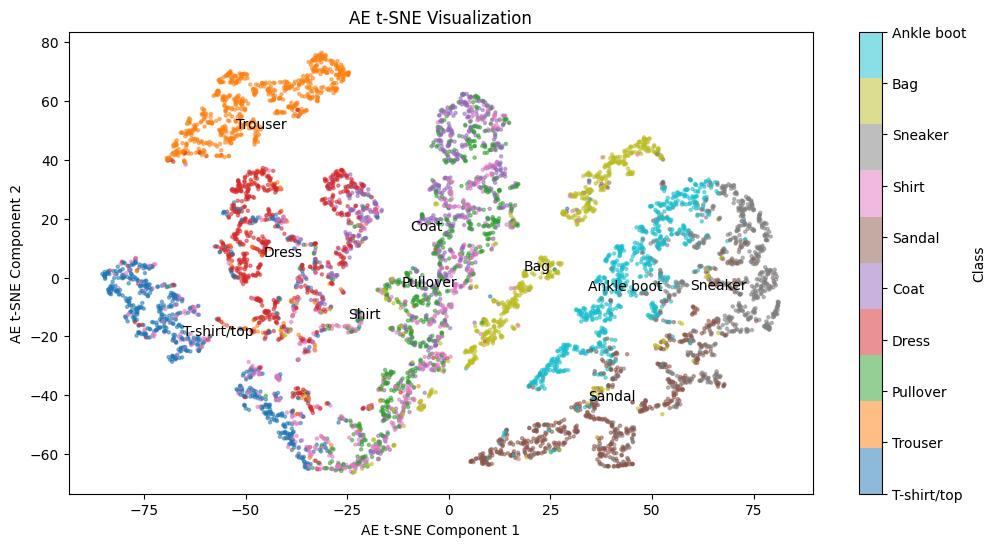

In [45]:
tsne = TSNE(n_components=2, random_state=RANDOM_STATE)
embeddings_tsne = tsne.fit_transform(embeddings)
visualize_2d(embeddings_tsne, y_test, 'AE t-SNE')

# Train a Classifier (8 points)

In the previous part, we saw that the encoder has learned to project images into representations with semantic meaning. In this part, you will transfer the knowledge learned by the encoder to a classification task by adding classification layers on top of it. This is a common technique in transfer learning, and it can be used to improve the performance of a classifier on a new task, even if the classifier is trained on a limited amount of data

In [51]:
def get_encoder(autoencoder):
    encoder = autoencoder.encoder
    return nn.Sequential(*list(encoder.children())[:-1])

class Classifier(nn.Module):
    def __init__(self, encoder, num_classes):
        super(Classifier, self).__init__()
        self.encoder = encoder
        self.classifier_layer = nn.Sequential(
            nn.Linear(12, num_classes)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.encoder(x)
        x = self.classifier_layer(x)
        return x

encoder = get_encoder(autoencoder)
classifier = Classifier(encoder, len(class_names))
classifier.to(device)

Classifier(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): ReLU()
  )
  (classifier_layer): Sequential(
    (0): Linear(in_features=12, out_features=10, bias=True)
  )
)

## Training Loop (9 Points)

Implement the `train_clf_epoch`, `test_clf`, and `train_clf` functions. In the `test_clf` function, in addition to the loss, calculate and return the accuracy.


In [52]:
def train_clf_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    mean_loss = train_loss / len(train_loader)
    return mean_loss

def test_clf(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    mean_loss = test_loss / len(test_loader)
    return mean_loss, accuracy

def train_clf(model, train_loader, val_loader, num_epochs, device):
    learning_rate = 1e-3
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    train_loss_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        train_loss = train_clf_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = test_clf(model, val_loader, criterion, device)
        scheduler.step()

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val ACC: {100 * val_acc:.2f}")

        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

    return train_loss_history, val_loss_history, val_acc_history

clf_train_loss_history, clf_val_loss_history, clf_val_acc_history = train_clf(classifier, train_loader, val_loader, 30, device)


Epoch 1/30, Train Loss: 0.9498, Val Loss: 0.4893, Val ACC: 83.05
Epoch 2/30, Train Loss: 0.4426, Val Loss: 0.4129, Val ACC: 85.35
Epoch 3/30, Train Loss: 0.3839, Val Loss: 0.3866, Val ACC: 86.01
Epoch 4/30, Train Loss: 0.3561, Val Loss: 0.3601, Val ACC: 87.01
Epoch 5/30, Train Loss: 0.3362, Val Loss: 0.3481, Val ACC: 87.32
Epoch 6/30, Train Loss: 0.3211, Val Loss: 0.3415, Val ACC: 87.75
Epoch 7/30, Train Loss: 0.3093, Val Loss: 0.3390, Val ACC: 87.75
Epoch 8/30, Train Loss: 0.2971, Val Loss: 0.3351, Val ACC: 87.81
Epoch 9/30, Train Loss: 0.2870, Val Loss: 0.3398, Val ACC: 87.68
Epoch 10/30, Train Loss: 0.2800, Val Loss: 0.3437, Val ACC: 87.62
Epoch 11/30, Train Loss: 0.2487, Val Loss: 0.3116, Val ACC: 88.66
Epoch 12/30, Train Loss: 0.2444, Val Loss: 0.3107, Val ACC: 88.80
Epoch 13/30, Train Loss: 0.2426, Val Loss: 0.3101, Val ACC: 88.87
Epoch 14/30, Train Loss: 0.2406, Val Loss: 0.3090, Val ACC: 88.80
Epoch 15/30, Train Loss: 0.2391, Val Loss: 0.3093, Val ACC: 88.89
Epoch 16/30, Train 

## Visualize Losses

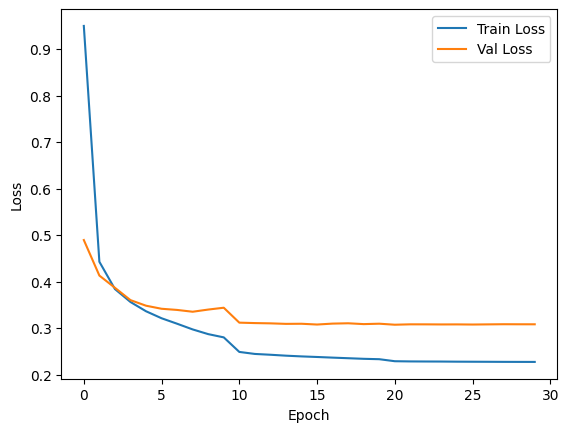

In [53]:
plt.plot(clf_train_loss_history, label='Train Loss')
plt.plot(clf_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Visualize Validation Accuracy

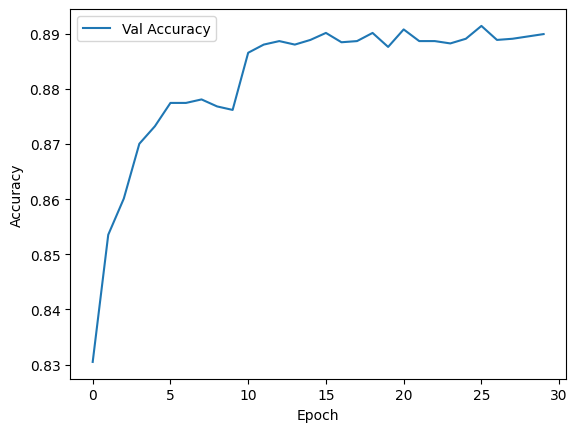

In [54]:
plt.plot(clf_val_acc_history, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Evaluate on Testset (20 points)

Your model must achieve an accuracy of at least 90% on the test set to receive full marks.

In [55]:
test_loss, test_acc = test_clf(classifier, test_loader, nn.CrossEntropyLoss(), device)

print(f"Test Loss: {test_loss:.4f}, Test ACC: {100 * test_acc:.2f}")

Test Loss: 0.2904, Test ACC: 89.36
